In [116]:
from netCDF4 import Dataset
import numpy as np
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [11]:
def get_per_time_slot_values(prcp):
    per_interval_prcp = (prcp[1:] - prcp[:-1])
    return per_interval_prcp

def datetime_utc_to_lk(timestamp_utc, shift_mins=0):
    return timestamp_utc + timedelta(hours=5, minutes=30 + shift_mins)

In [12]:
def read_netcdf(netcdf_file):
    nnc_fid = Dataset(netcdf_file, mode='r')
    time_unit_info = nnc_fid.variables['XTIME'].units
    print('time_unit_info : ', time_unit_info)
    time_unit_info_list = time_unit_info.split('since ')
    print(time_unit_info_list)

    lats = nnc_fid.variables['XLAT'][0, :, 0]
    lons = nnc_fid.variables['XLONG'][0, 0, :]

    lon_min = lons[0].item()
    lat_min = lats[0].item()
    lon_max = lons[-1].item()
    lat_max = lats[-1].item()

    lat_inds = np.where((lats >= lat_min) & (lats <= lat_max))
    lon_inds = np.where((lons >= lon_min) & (lons <= lon_max))

    rainnc = nnc_fid.variables['RAINNC'][:, lat_inds[0], lon_inds[0]]
    times = nnc_fid.variables['XTIME'][:]
    nnc_fid.close()
    
    diff = get_per_time_slot_values(rainnc)
    width = len(lons)
    height = len(lats)
    
    ts_df_list = []
    timestamp_list = []
    
    for i in range(len(diff)):
        ts_time = datetime.strptime(time_unit_info_list[1], '%Y-%m-%dT%H:%M:%S') + timedelta(minutes=times[i + 1].item())
        t = datetime_utc_to_lk(ts_time, shift_mins=0)
        timestamp = t.strftime('%Y-%m-%d %H-%M-%S')
        timestamp_list.append(timestamp)
        ts_list = []
        for y in range(height):
            for x in range(width):
                lat = float('%.6f' % lats[y])
                lon = float('%.6f' % lons[x])
                rain = '%.3f' % float(diff[i, y, x])
                ts_list.append([lon, lat, rain])
        ts_df = pd.DataFrame(ts_list, columns=['Lon', 'Lat', 'Rain'])
        ts_df_list.append(ts_df)
    return ts_df_list

In [13]:
read_netcdf('/home/hasitha/Desktop/Jean_A_d03_RAINNC.nc')

time_unit_info :  minutes since 2019-10-28T18:00:00
['minutes ', '2019-10-28T18:00:00']


[             Lon        Lat   Rain
 0      79.521461   5.722969  0.000
 1      79.548691   5.722969  0.000
 2      79.575920   5.722969  0.000
 3      79.603149   5.722969  0.000
 4      79.630379   5.722969  0.000
 ...          ...        ...    ...
 16033  82.081001  10.064255  0.000
 16034  82.108231  10.064255  0.000
 16035  82.135460  10.064255  0.000
 16036  82.162689  10.064255  0.000
 16037  82.189919  10.064255  0.000
 
 [16038 rows x 3 columns],              Lon        Lat   Rain
 0      79.521461   5.722969  0.000
 1      79.548691   5.722969  0.000
 2      79.575920   5.722969  0.000
 3      79.603149   5.722969  0.000
 4      79.630379   5.722969  0.000
 ...          ...        ...    ...
 16033  82.081001  10.064255  0.000
 16034  82.108231  10.064255  0.000
 16035  82.135460  10.064255  0.000
 16036  82.162689  10.064255  0.000
 16037  82.189919  10.064255  0.000
 
 [16038 rows x 3 columns],              Lon        Lat   Rain
 0      79.521461   5.722969  0.000
 1      

In [98]:
def filter_grid_point(df, lat, lon):
    filtered_df = df[(df['Lat']==lat) & (df['Lon']==lon)]
    if not filtered_df.empty:
        rain = filtered_df.iloc[0]['Rain']
        return rain
    else:
        return 0.0

In [102]:
def get_netcdf_rfield(netcdf_file,grid_lon, grid_lat):
    nnc_fid = Dataset(netcdf_file, mode='r')
    time_unit_info = nnc_fid.variables['XTIME'].description
    time_unit_info_list = time_unit_info.split('since ')

    lats = nnc_fid.variables['XLAT'][0, :, 0]
    lons = nnc_fid.variables['XLONG'][0, 0, :]

    lon_min = lons[0].item()
    lat_min = lats[0].item()
    lon_max = lons[-1].item()
    lat_max = lats[-1].item()

    lat_inds = np.where((lats >= lat_min) & (lats <= lat_max))
    lon_inds = np.where((lons >= lon_min) & (lons <= lon_max))

    rainnc = nnc_fid.variables['RAINNC'][:, lat_inds[0], lon_inds[0]]
    times = nnc_fid.variables['XTIME'][:]
    nnc_fid.close()
    
    #diff = get_per_time_slot_values(rainnc)
    diff = rainnc
    width = len(lons)
    height = len(lats)
    
    plot_list = []
    
    for i in range(len(diff)):
        ts_time = datetime.strptime(time_unit_info_list[1], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=times[i].item())
        t = datetime_utc_to_lk(ts_time, shift_mins=0)
        timestamp = t.strftime('%Y-%m-%d %H-%M-00')
        ts_list = []
        for y in range(height):
            for x in range(width):
                lat = float('%.6f' % lats[y])
                lon = float('%.6f' % lons[x])
                rain = '%.3f' % float(diff[i, y, x])
                ts_list.append([lon, lat, rain])
        ts_df = pd.DataFrame(ts_list, columns=['Lon', 'Lat', 'Rain'])
        grid_point_rain = float(filter_grid_point(ts_df, grid_lat, grid_lon))
        plot_list.append([timestamp, grid_point_rain])
    return plot_list

In [103]:
plot_list = get_netcdf_rfield('/home/hasitha/Desktop/wrf_4.0_d0_18_2019-10-27_SE_d03_RAINNC.nc',80.556168, 7.102936)
print(plot_list)

[['2019-10-25 23-30-00', 0.0], ['2019-10-25 23-45-00', 0.0], ['2019-10-26 00-00-00', 0.0], ['2019-10-26 00-15-00', 0.0], ['2019-10-26 00-30-00', 0.0], ['2019-10-26 00-45-00', 0.0], ['2019-10-26 01-00-00', 0.0], ['2019-10-26 01-15-00', 0.001], ['2019-10-26 01-30-00', 0.001], ['2019-10-26 01-45-00', 0.012], ['2019-10-26 02-00-00', 0.022], ['2019-10-26 02-15-00', 0.028], ['2019-10-26 02-30-00', 0.033], ['2019-10-26 02-45-00', 0.036], ['2019-10-26 03-00-00', 0.036], ['2019-10-26 03-15-00', 0.037], ['2019-10-26 03-30-00', 0.039], ['2019-10-26 03-45-00', 0.04], ['2019-10-26 04-00-00', 0.041], ['2019-10-26 04-15-00', 0.046], ['2019-10-26 04-30-00', 0.057], ['2019-10-26 04-45-00', 0.063], ['2019-10-26 05-00-00', 0.063], ['2019-10-26 05-15-00', 0.063], ['2019-10-26 05-30-00', 0.063], ['2019-10-26 05-45-00', 0.063], ['2019-10-26 06-00-00', 0.063], ['2019-10-26 06-15-00', 0.063], ['2019-10-26 06-30-00', 0.063], ['2019-10-26 06-45-00', 0.063], ['2019-10-26 07-00-00', 0.063], ['2019-10-26 07-15-00'

In [104]:
df = pd.DataFrame(plot_list, columns=['Time','Rain'])
#df.set_index('Time', inplace=True)
df

,Time,Rain
0,2019-10-25 23-30-00,0.000
1,2019-10-25 23-45-00,0.000
2,2019-10-26 00-00-00,0.000
3,2019-10-26 00-15-00,0.000
4,2019-10-26 00-30-00,0.000
...,...,...
284,2019-10-28 22-30-00,48.934
285,2019-10-28 22-45-00,48.934
286,2019-10-28 23-00-00,48.934
287,2019-10-28 23-15-00,48.934


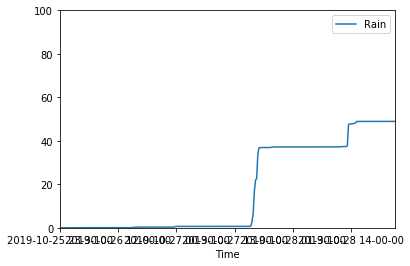

In [105]:
ax = plt.gca()
ax.set_ylim(0,100)
df.plot(kind='line',x='Time',y='Rain',ax=ax)
plt.show()

In [108]:
def plot_grid_point_rfield(rain_source, netcdf_file,grid_lon, grid_lat):
    plot_list = get_netcdf_rfield(netcdf_file,grid_lon, grid_lat)
    if len(plot_list)>0:
        df = pd.DataFrame(plot_list, columns=['Time',rain_source])
        return df
    else:
        return None

In [111]:
def get_df_list_grid_point_rfield(rain_source_list, netcdf_file_list,grid_lon, grid_lat):
    df_list = []
    i = 0
    for netcdf_file in netcdf_file_list:
        df = plot_grid_point_rfield(rain_source_list[i], netcdf_file,grid_lon, grid_lat)
        i+=1
        if df is not None:
            df_list.append(df)
    return df_list

In [112]:
netcdf_files = ['/home/hasitha/Desktop/wrf_4.0_d0_18_2019-10-27_A_d03_RAINNC.nc', '/home/hasitha/Desktop/wrf_4.0_d0_18_2019-10-27_C_d03_RAINNC.nc', '/home/hasitha/Desktop/wrf_4.0_d0_18_2019-10-27_E_d03_RAINNC.nc','/home/hasitha/Desktop/wrf_4.0_d0_18_2019-10-27_SE_d03_RAINNC.nc']
rain_sources = ['A','C','E','SE']

In [114]:
df_list = get_df_list_grid_point_rfield(rain_sources, netcdf_files, 80.556168, 7.102936)

In [117]:
plot_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time'), df_list)
plot_df

,Time,A,C,E,SE
0,2019-10-25 23-30-00,0.000,0.000,0.000,0.000
1,2019-10-25 23-45-00,0.000,0.000,0.000,0.000
2,2019-10-26 00-00-00,0.000,0.000,0.000,0.000
3,2019-10-26 00-15-00,0.000,0.000,0.000,0.000
4,2019-10-26 00-30-00,0.000,0.000,0.000,0.000
...,...,...,...,...,...
284,2019-10-28 22-30-00,6.868,28.502,12.021,48.934
285,2019-10-28 22-45-00,6.868,28.502,12.027,48.934
286,2019-10-28 23-00-00,6.868,28.502,12.030,48.934
287,2019-10-28 23-15-00,6.868,28.502,12.030,48.934


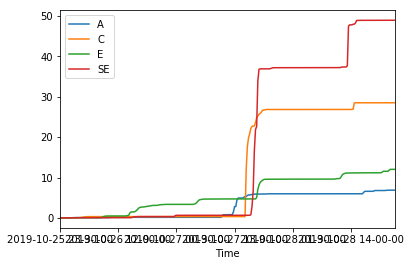

In [119]:
plot_df.plot(x="Time", y=["A", "C", "E", "SE"], kind="line")